In [1]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import cv2

In [14]:
labels_names =['a','b','c','d','e','f','g','h','$','#']
# Loading Data
data_test = np.load('X_test.npy')
labels_test = np.load('y_test.npy')
data_test = data_test.T

In [3]:
def bint(img):
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    thresh = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY_INV)[1] #100
    # thresh = cv2.threshold(blurred,0,255,cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)[1] 
    kernel = np.ones((3,1), np.uint8)
    erode = cv2.erode(thresh, kernel, iterations=0)
    kernel = np.ones((1,3), np.uint8)
    erode = cv2.erode(erode, kernel, iterations=0)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
    dilate = cv2.dilate(erode, kernel , iterations=1)

    # Find contours in the image
    cnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    bcr = 175
    threshold_min_radius = 16
    threshold_min_area = 256
    mxr = threshold_min_radius
    mxa = threshold_min_area
    x,y,r = [0]*3
    cnt = 0
    for c in cnts:
        (cx,cy),cr = cv2.minEnclosingCircle(c)
        [cx,cy,cr] = [int(i) for i in [cx,cy,cr]]
        (bx,by),(bw,bh),a = cv2.minAreaRect(c)
        # area = cv2.contourArea(c)
        dis = math.sqrt((cx - 150)**2 + (cy - 150)**2)
        overlap =  (dis + cr) <= bcr and dis < 50
        inside = (cx - cr) > 0 and (cy - cr) > 0 and (cx + cr) < 300 and (cy + cr) < 300
        if cr > threshold_min_radius and (inside or overlap) and bw*bh > mxa and min(bw, bh)/max(bw, bh) > 0.32:
            # cv2.drawContours(original_image,[c], 0, (0,255,0), 3)
            if True:
                cnt = c
                mxr = cr
                mxa = bw*bh
                x,y,r = [int(i) for i in [cx,cy,cr]]
        # if area > 10000 and 120 < (bx+bw)/2 < 180 and 120 < (bx+bw)/2 < 180:
        #     cv2.rectangle(dilate, (bx,by), (bx+bw,by+bh), (255,255,255),2)
    return x,y,r,mxa,cnt
    

In [4]:
def lint(image):
    image = cv2.GaussianBlur(image, (3, 3), 0)
    edges = cv2.Canny(image=image, threshold1=100, threshold2=200)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    edges = cv2.dilate(edges, kernel , iterations=1)


    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200, None, 0, 0)

    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(edges, pt1, pt2, (0,0,0), 2, cv2.LINE_AA)
#             cv2.line(pimg, pt1, pt2, (64,64,64), 3, cv2.LINE_AA)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    imlin = cv2.dilate(edges, kernel , iterations=2)
    # Find contours in the image
    cnts = cv2.findContours(imlin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    bcr = 175
    threshold_min_radius = 16
    threshold_min_area = 256
    mxr = threshold_min_radius
    mxa = threshold_min_area
    x,y,r = [0]*3
    cnt = 0
    for c in cnts:
        (cx,cy),cr = cv2.minEnclosingCircle(c)
        [cx,cy,cr] = [int(i) for i in [cx,cy,cr]]
        (bx,by),(bw,bh),a = cv2.minAreaRect(c)
        # area = cv2.contourArea(c)
        dis = math.sqrt((cx - 150)**2 + (cy - 150)**2)
        overlap =  (dis + cr) <= bcr and dis < 50
        inside = (cx - cr) > 0 and (cy - cr) > 0 and (cx + cr) < 300 and (cy + cr) < 300
        if cr > threshold_min_radius and (inside) and bw*bh > mxa and min(bw, bh)/max(bw, bh) > 0.32:
            # cv2.drawContours(original_image,[c], 0, (0,255,0), 3)
            if True:
                cnt = c
                mxr = cr
                mxa = bw*bh
                x,y,r = [int(i) for i in [cx,cy,cr]]
        # if area > 10000 and 120 < (bx+bw)/2 < 180 and 120 < (bx+bw)/2 < 180:
        #     cv2.rectangle(dilate, (bx,by), (bx+bw,by+bh), (255,255,255),2)
    return imlin,lines,x,y,r,mxa,cnt


In [5]:
def otsu(pimg):
    blurred = cv2.GaussianBlur(pimg, (3, 3), 0)
    thresh = cv2.threshold(blurred,0,255,cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)[1] 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    imotsu = cv2.dilate(thresh, kernel , iterations=1)

    x,y,r = [0]*3
    # Find contours in the image
    cnts = cv2.findContours(imotsu.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    threshold_min_radius = 13
    threshold_min_area = 256
    mxr = threshold_min_radius
    mxa = threshold_min_area
    x,y,r = [0]*3
    cnt = 0
    for c in cnts:
        (cx,cy),cr = cv2.minEnclosingCircle(c)
        [cx,cy,cr] = [int(i) for i in [cx,cy,cr]]
        (bx,by),(bw,bh),a = cv2.minAreaRect(c)
        # if cr > 100 and 200 < cx < 100 and 200 < cy < 100:
        #     continue
        inside = (cx - cr) > 0 and (cy - cr) > 0 and (cx + cr) < 300 and (cy + cr) < 300
        if cr > mxr and inside and bw*bh > 1600 and min(bw, bh)/max(bw, bh) > 0.25:
            # cv2.drawContours(original_image,[c], 0, (0,255,0), 3)
            if True:
                cnt = c
                mxr = cr
                mxa = bw*bh
                x,y,r = [cx,cy,cr]
    return imotsu,x,y,r,mxa,cnt


In [6]:
#Data Augmentation
import numpy as np
import cv2
import math
def augment_data(data_train, labels_train, train=False, imsize=300):
    data = []
    labels = []
    k = 1000
    for t in range(len(data_train)):
        res = []
        img = np.copy(data_train[t].reshape((imsize,imsize)))
        pimg = np.copy(data_train[t].reshape((imsize,imsize)))
        image = np.copy(data_train[t].reshape(imsize, imsize))

        imlin,lines,x,y,r,mxa,cnt = lint(image)
        lincon = cnt
    #         cv2.circle(edges, (x,y), r, (255,255,255),2)
        res.append((x,y,r,mxa))



        blurred = cv2.GaussianBlur(img, (3, 3), 0)
        thresh = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY_INV)[1] #100
        # thresh = cv2.threshold(blurred,0,255,cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)[1] 
        kernel = np.ones((3,1), np.uint8)
        erode = cv2.erode(thresh, kernel, iterations=0)
        kernel = np.ones((1,3), np.uint8)
        erode = cv2.erode(erode, kernel, iterations=0)
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
        imbin = cv2.dilate(erode, kernel , iterations=1)


        x,y,r,mxa,cnt = bint(img)
        if r == 0:
            img = np.copy(data_train[t].reshape((imsize,imsize)))
            img = np.roll(img, 25, axis=0)
            x,y,r,mxa,cnt = bint(img)
            if r != 0: y -= 25
        if r == 0:
            img = np.copy(data_train[t].reshape((imsize,imsize)))
            img = np.roll(img, -25, axis=0)
            x,y,r,mxa,cnt = bint(img)
            if r != 0: y += 25
        if r == 0:
            img = np.copy(data_train[t].reshape((imsize,imsize)))
            img = np.roll(img, 25, axis=1)
            x,y,r,mxa,cnt = bint(img)
            if r != 0: x -= 25
        if r == 0:
            img = np.copy(data_train[t].reshape((imsize,imsize)))
            img = np.roll(img, -25, axis=1)
            x,y,r,mxa,cnt = bint(img)
            if r != 0: x += 25

        bincon = cnt
    #         cv2.circle(dilate, (x,y), r, (255,255,255),2)
        res.append((x,y,r,mxa))


        imotsu,x,y,r,mxa,cnt = otsu(pimg)
        otsucon = cnt
    #         cv2.circle(dilate, (x,y), r, (255,255,255),2)
        # cv2.drawContours(pimg,[cnt], 0, (0,255,0), 3)
        # cv2.rectangle(pimg, (x-r,y-r), (x+r, y+r), (0,255,0),1)
        res.append((x,y,r,mxa))

        edge_x, edge_y, edge_r, edge_a = res[0]
        bin_x, bin_y, bin_r, bin_a = res[1]
        otsu_x, otsu_y, otsu_r, otsu_a = res[2]
        x,y,r = (150,150,150)
        found = res != [(0,0,0,256), (0,0,0,256), (0,0,0,256)]
        con = bincon
        img = imbin
    #     ax = fig.add_subplot(100,10,t+1)
        x,y,s = (0,0,300)
        if found:
            if otsu_a > bin_a:
                con = otsucon
                img = imotsu
            oa = 0
            if bin_a == 256 and otsu_a == 256:
                oa = 1
            if edge_a > bin_a and edge_a > otsu_a and (oa > 0.75 or lines is None):
                con = lincon
                img = imlin
            if con is bincon:
                x,y,w,h = bin_x-bin_r, bin_y-bin_r, 2*bin_r, 2*bin_r
            else:
                x,y,w,h = cv2.boundingRect(con)
            s = 0
            if h > w:
                y -= 10
                h += 20
                x = x + w//2 - h//2
                s = h
            else:
                x -= 10
                w += 20
                y = y + h//2 - w//2
                s = w
            x = x if x > 0 else 0
            y = y if y > 0 else 0
            s = s if s < 300 else 300
    #         im = cv2.cvtColor(data_train[:,t+j*100].reshape((300,300)), cv2.COLOR_GRAY2BGR)
    #         cv2.rectangle(im, (x,y), (x+s, y+s), (0,0,0),2)

    #         x,y,w,h = cv2.boundingRect(lincon) if edge_a > 256 else (0,0,300,300)
    #         cv2.rectangle(im, (x,y), (x+w, y+h), (255,0,0),2)
    #         x,y,w,h = cv2.boundingRect(bincon) if bin_a > 256 else (0,0,300,300)
    #         cv2.rectangle(im, (x,y), (x+w, y+h), (0,255,0),2)
    #         x,y,w,h = cv2.boundingRect(otsucon) if otsu_a > 256 else (0,0,300,300)
    #         cv2.rectangle(im, (x,y), (x+w, y+h), (0,0,255),2)


        im = np.copy(data_train[t].reshape((imsize,imsize)))
        char = cv2.resize(im[y:y+s, x:x+s],(50,50),interpolation = cv2.INTER_AREA).astype(np.uint8)
        char = np.invert(char.astype(np.uint8))

        ud = char
        du = np.flip(ud)
        data.append(ud)
        data.append(du)
        labels.append(labels_train[t])
        labels.append(labels_train[t])
        if train:
            sh = np.roll(ud, (2*npr.randint(0, 1)-1)*5, axis=0)
            sh = np.roll(sh, (2*npr.randint(0, 1)-1)*5, axis=1)
            data.append(sh)
            sh = np.roll(du, (2*npr.randint(0, 1)-1)*5, axis=0)
            sh = np.roll(sh, (2*npr.randint(0, 1)-1)*5, axis=1)
            data.append(sh)
            labels.append(labels_train[t])
            labels.append(labels_train[t])

        
        if s < 300:   
            ud = cv2.resize(img[y:y+s, x:x+s],(50,50),interpolation = cv2.INTER_AREA).astype(np.uint8)
        du = np.flip(ud)
        data.append(ud)
        data.append(du)
        labels.append(labels_train[t])
        labels.append(labels_train[t])
        if train:
            sh = np.roll(ud, (2*npr.randint(0, 1)-1)*5, axis=0)
            sh = np.roll(sh, (2*npr.randint(0, 1)-1)*5, axis=1)
            data.append(sh)
            sh = np.roll(du, (2*npr.randint(0, 1)-1)*5, axis=0)
            sh = np.roll(sh, (2*npr.randint(0, 1)-1)*5, axis=1)
            data.append(sh)
            labels.append(labels_train[t])
            labels.append(labels_train[t])


        ud = cv2.resize(im,(50,50),interpolation = cv2.INTER_AREA).astype(np.uint8)
        du = np.flip(ud)
        data.append(ud)
        data.append(du)
        labels.append(labels_train[t])
        labels.append(labels_train[t])
        if train:
            sh = np.roll(ud, (2*npr.randint(0, 1)-1)*5, axis=0)
            sh = np.roll(sh, (2*npr.randint(0, 1)-1)*5, axis=1)
            data.append(sh)
            sh = np.roll(du, (2*npr.randint(0, 1)-1)*5, axis=0)
            sh = np.roll(sh, (2*npr.randint(0, 1)-1)*5, axis=1)
            data.append(sh)
            labels.append(labels_train[t])
            labels.append(labels_train[t])




    #     plt.imshow(char, cmap='gray') 
    return np.array(data), np.array(labels)

In [7]:
from tensorflow.keras.utils import to_categorical
def preprocess_data(X, y,imsize=50):
#   # reshape images to the required size of Keras
    X = X.reshape(X.shape[0], imsize, imsize, 1)

    # convert image values from integers to floats
    X = X.astype('float32')

    # normalization
    X = X/255.0

    # One-hot encoding label 
    y = to_categorical(y)

    return X, y

In [8]:
# define cnn model
def PandaNet(input_shape):
    model = Sequential([
    tf.keras.Input(shape=input_shape),
    Conv2D(16, (5, 5), activation='relu', padding = 'same', kernel_initializer='he_uniform'),
    MaxPooling2D((2, 2), strides=(2)),

    Conv2D(32, (5,5),activation='relu', kernel_initializer='he_uniform'),
    MaxPooling2D((2, 2), strides=(2)),

    Conv2D(64,(3,3), activation='relu', kernel_initializer='he_uniform'),
    MaxPooling2D((2, 2), strides=(2)),

    Flatten(),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'),
    Dropout(0.2),
    Dense(11, activation='softmax')
    ])
    # compile model
    opt = Adam(learning_rate=0.0001 , epsilon=1e-5)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
def test(model, data_test, labels_test):
    X_test, y_test = augment_data(data_test, labels_test)
    # Rescaling all training and testing data
    X_test, y_test = preprocess_data(X_test, y_test)
    # Fitting the model on the training set
    pred = model.predict(X_test)
    pred = pred.reshape(-1, 6, pred.shape[1]).mean(axis = 1)
    pred[:,10] = 0 #Easy Test has no unknown classes
    plab = np.argmax(pred, axis=1)
    acc = accuracy_score(labels_test, plab)
    return acc, plab


In [12]:
model = load_model('PandaNet')

In [15]:
acc, pred = test(model, data_test, labels_test)

2022-04-22 15:05:16.132674: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-22 15:05:16.847194: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-04-22 15:05:17.721818: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-04-22 15:05:17.806188: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-22 15:05:18.879269: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


0.9627976190476191


Text(54.5, 0.5, 'True classes')

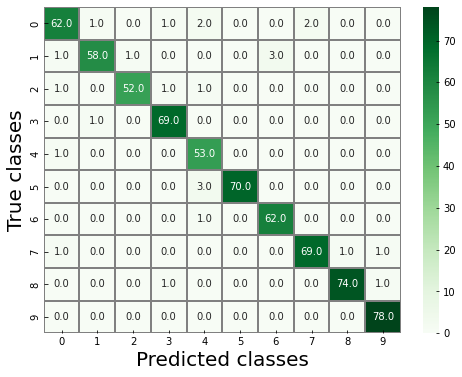

In [16]:
print(acc)
from sklearn.metrics import confusion_matrix
import seaborn as sns 

con_mat = confusion_matrix(labels_test, pred)

plt.figure(figsize = (8,6))
sns.heatmap(con_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', 
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)